In [1]:
import numpy as np
import os
import pathlib
import cv2
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import accuracy_score, classification_report, precision_score, recall_score, f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from keras.applications.mobilenet_v2 import MobileNetV2
from keras.layers import GlobalAveragePooling2D
from keras.models import Sequential
import matplotlib.pyplot as plt  # For displaying images

In [4]:
# Define constants
IMAGE_SHAPE = (200, 200)  # Resize all images to this shape for MobileNetV2
BATCH_SIZE = 100
DATA_DIR = 'F:/indhu/Datasets/dog_breed_30_images/'

In [5]:
# Load data
data_dir = pathlib.Path(DATA_DIR)
breeds = os.listdir(DATA_DIR)
dogs_images_dict = {}
dogs_labels_dict = {}
X, y = [], []
for index, category in enumerate(breeds):
    dogs_images_dict[category] = list(data_dir.glob(category + '/*'))
    dogs_labels_dict[category] = index

for breed_name, images in dogs_images_dict.items():
    for image in images:
        img = cv2.imread(str(image))
        gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)  # Convert to grayscale
        resized_img = cv2.resize(gray_img, IMAGE_SHAPE)  # Resize the grayscale image
        X.append(resized_img)
        y.append(dogs_labels_dict[breed_name])

X = np.array(X) / 255.0  # Normalize images
y = np.array(y)

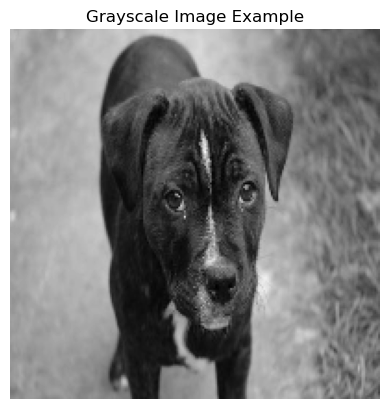

In [6]:

# Display a grayscale image
plt.imshow(X[0], cmap='gray')  # Display the first image in grayscale
plt.title("Grayscale Image Example")
plt.axis("off")
plt.show()


In [7]:
# Add channel dimension for grayscale images to match MobileNetV2 input shape
X = X[..., np.newaxis]
X = np.repeat(X, 3, axis=-1)  # Repeat the grayscale channel to create a 3-channel image

In [8]:

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [9]:
# Create MobileNetV2 feature extractor
base_model_mobilenet = MobileNetV2(input_shape=IMAGE_SHAPE + (3,), include_top=False, weights='imagenet')
base_model_mobilenet.trainable = False  # Freeze the convolutional base

feature_extractor_mobilenet = Sequential([
    base_model_mobilenet,
    GlobalAveragePooling2D()
])


C:\Users\Indhuma\AppData\Local\Temp\ipykernel_1892\1325366306.py:2: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model_mobilenet = MobileNetV2(input_shape=IMAGE_SHAPE + (3,), include_top=False, weights='imagenet')


In [10]:

# Extract features using MobileNetV2
X_train_features = feature_extractor_mobilenet.predict(X_train, batch_size=BATCH_SIZE, verbose=1)
X_test_features = feature_extractor_mobilenet.predict(X_test, batch_size=BATCH_SIZE, verbose=1)

39/39 ━━━━━━━━━━━━━━━━━━━━ 29s 707ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 6s 632ms/step


In [11]:
# Initialize classifiers
classifiers = {
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "Logistic Regression": LogisticRegression(max_iter=200, random_state=42),
    "K-Nearest Neighbors": KNeighborsClassifier(n_neighbors=5),
    "Support Vector Machine": SVC(kernel='rbf', probability=True, random_state=42),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Naive Bayes": GaussianNB()
}

In [ ]:
# Evaluate classifiers using test set
for model_name, model in classifiers.items():
    print(f"Evaluating {model_name}...")
    model.fit(X_train_features, y_train)
    y_pred = model.predict(X_test_features)
    print(f"{model_name} Accuracy: {accuracy_score(y_test, y_pred):.4f}")
    print(classification_report(y_test, y_pred))

# Evaluate classifiers using k-fold cross-validation
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
for clf_name, clf in classifiers.items():
    print(f"K-Fold Cross Validation for {clf_name}...")
    precision_scores = []
    recall_scores = []
    f1_scores = []
    accuracy_scores = []

    for train_index, val_index in kf.split(X_train_features, y_train):
        X_train_fold, X_val_fold = X_train_features[train_index], X_train_features[val_index]
        y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]

        clf.fit(X_train_fold, y_train_fold)
        y_val_pred = clf.predict(X_val_fold)

        accuracy_scores.append(accuracy_score(y_val_fold, y_val_pred))
        precision_scores.append(precision_score(y_val_fold, y_val_pred, average='weighted'))
        recall_scores.append(recall_score(y_val_fold, y_val_pred, average='weighted'))
        f1_scores.append(f1_score(y_val_fold, y_val_pred, average='weighted'))

    print(f"Average Accuracy: {np.mean(accuracy_scores):.4f}")
    print(f"Average Precision: {np.mean(precision_scores):.4f}")
    print(f"Average Recall: {np.mean(recall_scores):.4f}")
    print(f"Average F1 Score: {np.mean(f1_scores):.4f}\n")


Evaluating Random Forest...
Random Forest Accuracy: 0.7477
              precision    recall  f1-score   support

           0       0.76      0.68      0.72        41
           1       0.62      0.38      0.47        40
           2       0.91      0.72      0.81        29
           3       0.89      0.71      0.79        34
           4       0.68      0.58      0.62        33
           5       0.65      0.75      0.70        32
           6       0.76      0.87      0.81        39
           7       0.82      0.68      0.74        34
           8       0.44      0.52      0.48        31
           9       0.61      0.82      0.70        28
          10       0.79      0.93      0.85        28
          11       0.82      0.82      0.82        28
          12       0.83      0.76      0.79        25
          13       0.75      0.75      0.75        24
          14       0.76      0.84      0.80        31
          15       0.90      0.95      0.93        40
          16       0.6